In [1]:
# Import the necessary python packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

# Import datetime
from datetime import datetime

# For kinship and pedigree
import PyAGH
import graphviz

# Import API
import urllib.request, json, csv

# Generate the main dataframe

In [2]:
# Remove birds with no Dam or no Sire
# Define a function that drops rows
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

# Use the function:
# data = filter_rows_by_values(data, "sire", [None])

In [3]:
# Import the birds dataset
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/pedigree/?species=zebf") as url:
    data = pd.read_json(url)

# Clean up
data["uuid"] = data["uuid"].str[:6]
data["name"] = data["name"].str[5:]
data["sire"] = data["sire"].str[5:]
data["dam"] = data["dam"].str[5:]

# replace 'None' by 'origin' in sire/dam
data["sire"] = data["sire"].replace({None: "Origin"})
data["dam"] = data["dam"].replace({None: "Origin"})

In [25]:
# Import reserved_by
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/animals/?reserved_by=melizalab") as url:
    reservation = pd.read_json(url)

reservation = reservation[["uuid", "reserved_by"]]
reservation["uuid"] = reservation["uuid"].str[:6]

reservation = pd.merge(data, reservation, on=["uuid"])
reservation

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age,reserved_by
0,566d97,blue_201,blue_72,blue_113,F,0,gray,2017-04-02,NA,melizalab
1,4a36fc,bronze_144,Origin,Origin,F,0,gray,2017-10-14,NA,melizalab
2,8f1932,cobalt_12,purple_23,purple_77,F,0,silver,2021-02-28,NA,melizalab
3,33ad5c,cobalt_25,purple_29,cobalt_10,F,0,gray,2021-06-21,NA,melizalab
4,745712,cobalt_26,purple_83,cobalt_199,M,0,NaN,2021-06-22,NA,melizalab
...,...,...,...,...,...,...,...,...,...,...
80,01ba9f,purple_40,blue_72,blue_113,M,0,gray,2018-12-01,NA,melizalab
81,9ba391,purple_42,purple_92,purple_7,F,0,pied,2019-09-25,NA,melizalab
82,b3e583,purple_83,green_14,bronze_144,M,0,gray,2019-12-17,NA,melizalab
83,fb4a53,purple_92,blue_2,blue_8,M,0,silver,2016-10-18,NA,melizalab


In [5]:
# Calculate the age for all the birds
today = datetime.today()

# Convert acquisition into a timestamp
birth = pd.to_datetime(data['acquired_on'])

# Calculate
data["age"] = (today - birth).dt.days

# Convert in 0 & 1
data = data*1

for index, row in data.iterrows():
    if row['alive'] == 0:
        data.at[index, 'age'] = "NA"

data

/tmp/ipykernel_35350/2812513485.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[index, 'age'] = "NA"


,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age
0,f32cfc,blue_1,Origin,Origin,F,0,NaN,2014-04-09,NA
1,fc9219,blue_2,Origin,Origin,M,0,NaN,2014-04-09,NA
2,b44ef6,blue_3,Origin,Origin,M,0,NaN,2014-04-09,NA
3,55de87,blue_4,Origin,Origin,M,0,NaN,2014-04-09,NA
4,fafe58,blue_5,Origin,Origin,F,0,NaN,2014-04-09,NA
...,...,...,...,...,...,...,...,...,...
380,d99f0a,d99f0ad5,ruby_264,cobalt_114,U,1,NaN,2024-11-23,25.0
381,0dca67,0dca678d,ruby_264,cobalt_114,U,1,NaN,2024-11-21,27.0
382,ef3f5f,ef3f5f4b,Origin,Origin,M,0,NaN,NaN,NA
383,2ba8dd,2ba8dd91,ruby_255,ruby_276,U,1,NaN,2024-12-05,13.0


In [6]:
alive_birds = []

for index, row in data.iterrows():
    if row['alive'] == 1 :
        alive_birds.append(row)

alive_birds = pd.DataFrame(alive_birds) # Create a DataFrame of alive birds only

alive_birds

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age
74,9a09b0,cobalt_110,cobalt_57,purple_174,F,1,fawn,2023-01-11,707.0
75,cec999,cobalt_114,purple_104,cobalt_84,F,1,fawn,2023-02-17,670.0
77,a9167f,cobalt_122,cobalt_32,ruby_203,M,1,gray,2023-02-09,678.0
79,abad48,cobalt_126,cobalt_206,purple_179,M,1,gray,2023-02-21,666.0
81,6a3b1f,cobalt_137,cobalt_35,cobalt_10,M,1,gray,2023-03-21,638.0
...,...,...,...,...,...,...,...,...,...
379,9a11f0,9a11f059,cobalt_137,cobalt_245,U,1,NaN,2024-12-09,9.0
380,d99f0a,d99f0ad5,ruby_264,cobalt_114,U,1,NaN,2024-11-23,25.0
381,0dca67,0dca678d,ruby_264,cobalt_114,U,1,NaN,2024-11-21,27.0
383,2ba8dd,2ba8dd91,ruby_255,ruby_276,U,1,NaN,2024-12-05,13.0


Example of a Fertility Score Calculation (Hypothetical)

An example calculation could use specific thresholds for each factor. Suppose each of the factors contributes a score between 0 to 10, with higher scores representing better fertility potential. The formula might look like this:
F=(10−A)+H+(10−B)+L+M+S
F=(10−A)+H+(10−B)+L+M+S

Where:

    AA = Age (e.g., 30 might yield 7 points, while 40 yields 3 points)
    HH = Hormonal health (based on specific tests)
    BB = BMI (e.g., a BMI of 22 could yield 9 points, and 30 could yield 3 points)
    LL = Lifestyle (e.g., non-smoking, healthy diet = 8 points)
    MM = Medical history (e.g., no conditions = 10 points)
    SS = Semen analysis (e.g., normal sperm count = 10 points)

## Calculate kinship

In [7]:
ped = pd.DataFrame()

ped["id"] = data["name"]
ped["sire"] = data["sire"]
ped["dam"] = data["dam"]

ped = filter_rows_by_values(ped, "sire", ["Origin"]) # Filter out the birds brought from the store
ped

,id,sire,dam
16,blue_20,blue_11,blue_12
17,blue_30,blue_7,blue_13
18,blue_31,blue_7,blue_13
19,blue_34,blue_7,blue_15
20,blue_35,blue_7,blue_15
...,...,...,...
379,9a11f059,cobalt_137,cobalt_245
380,d99f0ad5,ruby_264,cobalt_114
381,0dca678d,ruby_264,cobalt_114
383,2ba8dd91,ruby_255,ruby_276


In [26]:
ped_selected = PyAGH.selectPed(data=ped, id=["0dca678d"], generation=5) # Print 3 generations of the chosen bird
ped_selected = PyAGH.sortPed(ped_selected)

In [27]:
sort_ped = PyAGH.sortPed(ped_selected) # Sort the pedigree first
A = PyAGH.makeA(sort_ped)

In [28]:
coef_inbreeding = PyAGH.coefInbreeding(A)
coef_inbreeding

,ID,F
0,blue_9,0.000000
1,red_249,0.000000
2,orange_34,0.000000
3,e1a98d00,0.000000
4,purple_6,0.000000
5,red_216,0.000000
6,red_56,0.000000
7,red_264,0.000000
8,green_79,0.000000
9,blue_16,0.000000


In [29]:
coef_kinship = PyAGH.coefKinship(A)
coef_kinship

,ID1,ID2,r
0,blue_9,blue_9,1.000000
1,blue_9,red_249,0.000000
2,blue_9,orange_34,0.000000
3,blue_9,e1a98d00,0.000000
4,blue_9,purple_6,0.000000
...,...,...,...
815,purple_152,ruby_264,0.511643
816,purple_152,0dca678d,0.265108
817,ruby_264,ruby_264,1.000000
818,ruby_264,0dca678d,0.506778


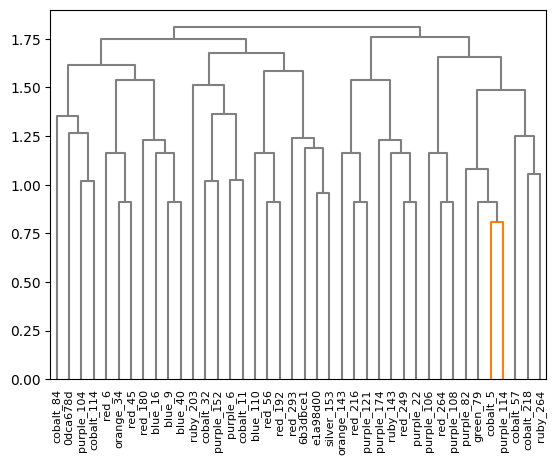

In [30]:
cluster_example = PyAGH.cluster(A)
plt.xticks(rotation=90)
plt.savefig('../output/cluster_example.png', facecolor='w', dpi=300)

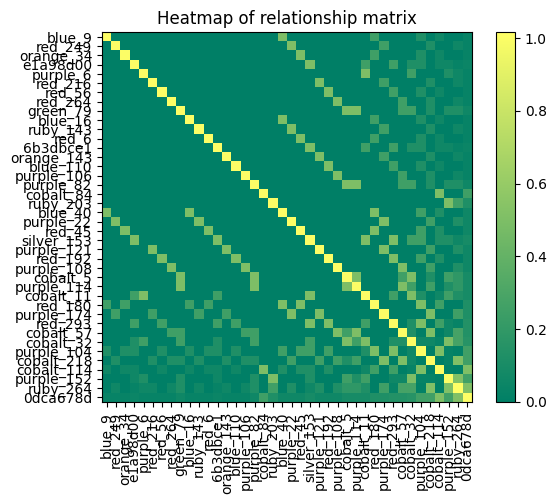

In [31]:
heatmap_example = PyAGH.heat(A)
plt.xticks(rotation=90)
plt.savefig('../output/heatmap_example.png', facecolor='w',dpi=500)

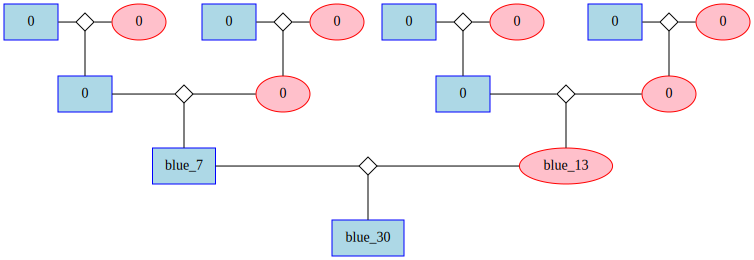

In [32]:
ped_selected = PyAGH.selectPed(data=ped,id=['blue_30'], generation=3) # Print selected number of generation of the bird
p = PyAGH.gragh(ped_selected)
graphviz.Source(p)

# Mastersheet events + birds

In [15]:
# Import the birds used for an experiment
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/events/?status=used") as url:
    used_birds = pd.read_json(url)

# Import the birds that died unexpectidly
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/events/?status=died") as url:
    died_birds = pd.read_json(url)

In [16]:
# Clean up
used_birds["uuid"] = used_birds["animal"].str[:6]
died_birds["uuid"] = died_birds["animal"].str[:6]

used_birds

,id,animal,date,status,location,description,entered_by,measurements,uuid
0,23977,ad5a2784-3189-401e-b5f2-b20e7266f90c,2024-12-16,used for in vivo,None,,bao.le,[],ad5a27
1,23947,47cba685-3bdd-4f68-8475-8801878e2cc4,2024-12-15,used for in vivo,None,perfused,afy9tp,[],47cba6
2,23952,453bfae1-9898-4f62-8b1c-3cacc2e142fa,2024-12-13,used for slices,None,,hfugate,[],453bfa
3,23932,75552c90-6876-457a-9d90-55eacbde8781,2024-12-12,used for slices,None,,bellanger,[],75552c
4,23886,5ccb6afc-c99e-4d53-bc66-f2d5d7870f18,2024-12-11,used for anatomy,None,shKIAA AAV inj - 3 weeks post,tbyron,[],5ccb6a
...,...,...,...,...,...,...,...,...,...
1660,4615,252bce9d-ed49-4473-a413-3c9f72db5c52,2014-06-10,used for slices,None,used in slice experiment,anc4kj,[],252bce
1661,4623,ab16f853-6725-46dc-b838-42c2d038817d,2014-06-05,used for slices,None,used in slice experiment,anc4kj,[],ab16f8
1662,4634,1f59f3b4-b489-47ce-8a29-2f09b4b2926f,2014-06-03,used for slices,None,used in slice experiment,dmeliza,[],1f59f3
1663,4635,891b1be4-d482-4b24-bc0d-f1d069dd1110,2014-06-02,used for slices,None,used in slice experiment,dmeliza,[],891b1b


In [17]:
# Add the list of events to the mastersheet
used_birds_ = pd.merge(
    data, used_birds, on=["uuid"]
)

died_birds_ = pd.merge(
    data, died_birds, on=["uuid"]
)

# Concatenate into a mastersheet
frames = [used_birds_, died_birds_]
mastersheet = pd.concat(frames)

In [18]:
mastersheet

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age,id,animal,date,status,location,description,entered_by,measurements
0,f32cfc,blue_1,Origin,Origin,F,0,NaN,2014-04-09,NA,3121,f32cfc45-45c4-4662-ab08-6b7f14f65697,2016-01-26,used for anatomy,None,"female had a bloody tumor on vent, perfused wi...",melizalab,[]
1,fc9219,blue_2,Origin,Origin,M,0,NaN,2014-04-09,NA,7151,fc921991-97d2-44de-a11d-959c556530a4,2019-12-06,used for anatomy,None,Perfusion with brain and feather extraction,smm3rc,[]
2,b44ef6,blue_3,Origin,Origin,M,0,NaN,2014-04-09,NA,3115,b44ef6df-9f7b-4a25-b431-ae3fbfd7980e,2016-01-31,used for anatomy,None,,ald5cd,[]
3,55de87,blue_4,Origin,Origin,M,0,NaN,2014-04-09,NA,3612,55de8708-1ac5-4cab-91d0-bb13030e3f71,2015-05-11,used for anatomy,None,,jpr5mh,[]
4,fafe58,blue_5,Origin,Origin,F,0,NaN,2014-04-09,NA,4099,fafe5888-38a7-422c-b229-ea63d4ecd180,2014-12-12,used for anatomy,None,,anc4kj,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,90e85f,ruby_216,purple_126,purple_122,F,0,gray,2022-01-28,NA,19664,90e85f6b-0091-46c8-a681-557889adbed1,2024-02-20,died,None,Didn't improve after over a week of treatment....,hfugate,[]
87,67374b,ruby_275,cobalt_35,cobalt_10,F,0,gray,2023-09-15,NA,23667,67374bdc-16ec-4864-b7be-62604af7b5c8,2024-11-18,died,None,"Failed operant and can't use for breeding, so ...",hfugate,[]
88,91eb33,silver_151,e1a98d00,6b3dbce1,F,0,gray,2017-12-05,NA,10264,91eb33bb-7036-4fdd-9375-ecb3131992d3,2021-09-20,died,None,Perfusion,tbyron,[]
89,9164ac,silver_153,e1a98d00,6b3dbce1,F,0,gray,2017-11-28,NA,14166,9164aca0-2204-43ef-bba7-bc27ab5fdc04,2022-10-18,died,None,showing as still alive,hfugate,[]


# Add kinship data to the mastersheet

In [19]:
sort_ped = PyAGH.sortPed(ped) # Select all the birds for analysis instead of a given bird
A = PyAGH.makeA(sort_ped)

coef_inbreeding = PyAGH.coefInbreeding(A)
coef_kinship = PyAGH.coefKinship(A)

# Making it shinny
coef_inbreeding["name"] = coef_inbreeding["ID"]
coef_inbreeding["coef_inbreeding"] = coef_inbreeding["F"]
coef_inbreeding = coef_inbreeding[["name", "coef_inbreeding"]]

In [20]:
mastersheet = pd.merge(
    mastersheet, coef_inbreeding, on=["name"]
)

In [21]:
mastersheet

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age,id,animal,date,status,location,description,entered_by,measurements,coef_inbreeding
0,f32cfc,blue_1,Origin,Origin,F,0,NaN,2014-04-09,NA,3121,f32cfc45-45c4-4662-ab08-6b7f14f65697,2016-01-26,used for anatomy,None,"female had a bloody tumor on vent, perfused wi...",melizalab,[],0.000000
1,fc9219,blue_2,Origin,Origin,M,0,NaN,2014-04-09,NA,7151,fc921991-97d2-44de-a11d-959c556530a4,2019-12-06,used for anatomy,None,Perfusion with brain and feather extraction,smm3rc,[],0.000000
2,b44ef6,blue_3,Origin,Origin,M,0,NaN,2014-04-09,NA,3115,b44ef6df-9f7b-4a25-b431-ae3fbfd7980e,2016-01-31,used for anatomy,None,,ald5cd,[],0.000000
3,9609f6,blue_9,Origin,Origin,M,0,NaN,2014-04-09,NA,4482,9609f65e-640e-4385-b458-e970c346dc79,2014-07-23,used for slices,Gilmer vivarium,used for histology,melizalab,[],0.000000
4,cebd65,blue_11,Origin,Origin,M,0,NaN,2014-04-09,NA,4131,cebd6517-657c-4979-b39b-5278d370682f,2014-12-02,used for slices,None,immuno,melizalab,[],0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,90e85f,ruby_216,purple_126,purple_122,F,0,gray,2022-01-28,NA,19664,90e85f6b-0091-46c8-a681-557889adbed1,2024-02-20,died,None,Didn't improve after over a week of treatment....,hfugate,[],-0.000000
195,67374b,ruby_275,cobalt_35,cobalt_10,F,0,gray,2023-09-15,NA,23667,67374bdc-16ec-4864-b7be-62604af7b5c8,2024-11-18,died,None,"Failed operant and can't use for breeding, so ...",hfugate,[],0.009277
196,91eb33,silver_151,e1a98d00,6b3dbce1,F,0,gray,2017-12-05,NA,10264,91eb33bb-7036-4fdd-9375-ecb3131992d3,2021-09-20,died,None,Perfusion,tbyron,[],-0.000000
197,9164ac,silver_153,e1a98d00,6b3dbce1,F,0,gray,2017-11-28,NA,14166,9164aca0-2204-43ef-bba7-bc27ab5fdc04,2022-10-18,died,None,showing as still alive,hfugate,[],-0.000000
